# Capstone Project - The Battle of Neighborhoods

## Introduction 

London house prices have soared more than in any other part of the UK since the 2007-08 financial crisis.

In fact, it is now so expensive buying a house in London that many first-time buyers (__target audience__ for this study) have given up and are sticking to renting. 

The business problem this project aims to solve is to identify which London District provides the best __value-for-money__ for a __two-bedrooms__ home (self-contained properties with two bedrooms including houses, bungalows, flats and maisonettes).
The overall rating score of each London District will be defined by looking at the following parameters:
   1. Monthly Rent
   2. Monthly Travelcard fare (commuting to __Zone 1__, Central London)
   3. Crime rate
   4. Most common venue categories and corresponding ratings (Foursquare API)

## Data

The following sources will be analysed in order to identify and collect the necessary information and data:
1. [Private rental market in London – July 2018 to June 2019](https://www.gov.uk/government/publications/private-rental-market-in-london-july-2018-to-june-2019)
UK Government official statistics on the private rental market in London covering July 2018 to June 2019 by region, borough and postcode district.
3. [Wikipedia List of London Boroughs](https://en.wikipedia.org/wiki/List_of_London_boroughs) The website page provides the required geographical details (latitude, longitue) for each of the London Districts.  
5. [Transport For London Tube and rail fares](http://content.tfl.gov.uk/adult-fares-2019.pdf) Adult rate prices for all Tube, DLR, London Overground and TfL Rail services and National Rail services in Zone 1-9. The analysis will include the monthly cost of commuting to Central London __Zone 1__.
6. [Recorded Crime: Geographic Breakdown](https://data.london.gov.uk/dataset/recorded_crime_summary) London Metropolitan Police crimes statistics for each London district.
5. [Foursquare API](https://developer.foursquare.com) Foursquare database to collect information on venue categories, tips, location data, venue ratings.

## Methodology

In __Step 1__ the required Pandas Dataframe is built: for each of the __32 London Districts__, this dataframe includes:
- The corresponding Postcode
- The corresponding London Zone (1-5)
- Average Monthly Rental Price for a __two-Bedrooms__ unit
- Monthly Travel Fares (commuting to Central London, __Zone 1__)
- Latitude and Longitude coordinates
- Crime Rate

In __Step 2__, exploratory data analysis is conducted: by using the __Seaborn__ library we identify few elements and patterns within the Dataframe (this includes correlation analysis, data visualization with heatmaps, histogram charts and pairplots) so that we can better assess the key characteristics of each District.


In __Step 3__ an inferential statistical testing is performed (__K Means Clustering__): the overall goal is to divide each District into groups such that we can determine which Districts are similar. In order to implement this analysis, we use Foursquare API to collect all the points of interest and venue categories for each District. Together with the results of the exploratory analysis from __Step 2__, we can thus determine which District provides the best __value-for-money__ for a __two-bedrooms__ home.


### Step 1

#### 1. Create a Pandas Dataframe containing each London postcode districts with the corresponding latitude and longitude coordinates, two-bedrooms average rental prices, transport fares and crime statistics

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import requests

In [2]:
London_df = pd.read_csv('https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London')

###### 1.1 Select required columns, remove Postcode not in use anymore

In [3]:
London_df.drop(London_df.loc[London_df['In Use?']=='No'].index, inplace=True)
London_df1 = London_df[['District', 'London zone', 'Postcode district']]
London_df1.head()

,District,London zone,Postcode district
0,Bromley,5,BR1
1,Bromley,4,BR1
3,Bromley,4,BR1
4,Bromley,5,BR1
5,Bromley,5,BR1


##### 1.2. For each District calculate its corresponding London Zone

In [4]:
average_df = pd.DataFrame(pd.pivot_table(London_df1, index=London_df1['District'], aggfunc='mean'))
average_df = average_df.round(0).astype(int)

In [5]:
average_df['District']=average_df.index

In [6]:
average_df.index= range(len(average_df.index))
average_df.head()

,London zone,District
0,5,Barking and Dagenham
1,4,Barnet
2,5,Bexley
3,3,Brent
4,5,Bromley


In [7]:
London_df_merged_one = London_df1.merge(average_df)
London_df_merged_one.sort_values('District', inplace = True)
London_df_merged_one.drop_duplicates(subset ='Postcode district', keep = 'first', inplace = True)

##### 1.3 Merge Private rental market data within the dataframe built in the previous step.

In [8]:
London_rental_df = pd.read_csv('https://raw.githubusercontent.com/BeppeBM/Coursera_Capstone/master/London_rental_statistics.csv')

In [9]:
London_rental_df.head()

,Postcode district,Monthly Rent Mean,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,BR1,1238,NaN,,NaN,NaN,NaN,NaN
1,BR2,1259,NaN,NaN,,NaN,NaN,NaN
2,BR3,1262,NaN,NaN,NaN,NaN,NaN,NaN
3,BR4,1113,NaN,NaN,,NaN,NaN,NaN
4,BR5,1092,NaN,NaN,,NaN,NaN,


In [10]:
London_rental_df.drop(['Unnamed: 2', 'Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7'], axis=1, inplace=True)
London_rental_df.head()

,Postcode district,Monthly Rent Mean
0,BR1,1238
1,BR2,1259
2,BR3,1262
3,BR4,1113
4,BR5,1092


In [11]:
London_df_merged_two = London_df_merged_one.merge(London_rental_df, how='left')

In [12]:
London_df_merged_two.head()

,District,London zone,Postcode district,Monthly Rent Mean
0,Barking and Dagenham,5,RM10,1114
1,Barking and Dagenham,5,RM5,1072
2,Barking and Dagenham,5,RM6,1117
3,Barking and Dagenham,5,RM8,1162
4,Barking and Dagenham,5,RM7,1158


##### 1.4. Merge Monthly Transport fares (commuting journey to Zone 1) within the dataframe built in the previous step.

In [13]:
London_travel_df = pd.read_csv('https://raw.githubusercontent.com/BeppeBM/Coursera_Capstone/master/adult-fares-2019.csv')
London_travel_df

,London zone,Monthly Travelcard
0,1,134.8
1,2,134.8
2,3,158.3
3,4,194.0
4,5,230.0
5,6,246.6
6,7,268.1
7,8,316.8
8,9,351.4


In [14]:
London_df_merged_three = London_df_merged_two.merge(London_travel_df, how='left')

In [15]:
London_df_merged_three['Total Monthly Cost'] = London_df_merged_three['Monthly Rent Mean'] + London_df_merged_three['Monthly Travelcard']
London_df_merged_three.head()

,District,London zone,Postcode district,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost
0,Barking and Dagenham,5,RM10,1114,230.0,1344.0
1,Barking and Dagenham,5,RM5,1072,230.0,1302.0
2,Barking and Dagenham,5,RM6,1117,230.0,1347.0
3,Barking and Dagenham,5,RM8,1162,230.0,1392.0
4,Barking and Dagenham,5,RM7,1158,230.0,1388.0


##### 1.5. Include Longitude and Latitude details of each District by scrapping the Wikipedia webpage.

In [16]:
URL = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
wiki = pd.read_html(URL)
London_Lat_Long = wiki[0]
London_Lat_Long.drop(['Inner', 'Status', 'Local authority', 'Political control', 'Headquarters', 'Area (sq mi)', 'Population (2013 est)[1]','Nr. in map'], axis=1, inplace=True)

In [17]:
London_Lat_Long.rename(columns={"Borough": "District"}, inplace=True)

In [18]:
London_Lat_Long['District'][0]= 'Barking and Dagenham'
London_Lat_Long['District'][9]= 'Greenwich'
London_Lat_Long['District'][11]= 'Hammersmith and Fulham'
London_Lat_Long.head()

,District,Co-ordinates
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E


In [19]:
London_Lat_Long['Co-ordinates_1'] = London_Lat_Long['Co-ordinates'].map(lambda x: x.split('/')[0])
London_Lat_Long['Latitude'] = London_Lat_Long['Co-ordinates_1'].map(lambda x: x.split(' ')[0])
London_Lat_Long['Longitude'] = London_Lat_Long['Co-ordinates_1'].map(lambda x: x.split(' ')[1])
London_Lat_Long.drop(['Co-ordinates', 'Co-ordinates_1'], axis=1, inplace=True)

In [20]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])

    return (lat)

In [21]:
London_Lat_Long['Latitude'] = London_Lat_Long['Latitude'].map(lambda x: parse_dms(x))
London_Lat_Long['Longitude'] = London_Lat_Long['Longitude'].map(lambda x: parse_dms(x))

In [22]:
London_df_merged_four = London_df_merged_three.merge(London_Lat_Long, how='left')
London_df_merged_four.head()

,District,London zone,Postcode district,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude
0,Barking and Dagenham,5,RM10,1114,230.0,1344.0,51.560833,0.155833
1,Barking and Dagenham,5,RM5,1072,230.0,1302.0,51.560833,0.155833
2,Barking and Dagenham,5,RM6,1117,230.0,1347.0,51.560833,0.155833
3,Barking and Dagenham,5,RM8,1162,230.0,1392.0,51.560833,0.155833
4,Barking and Dagenham,5,RM7,1158,230.0,1388.0,51.560833,0.155833


##### 1.6. Include Crime details of each District

In [23]:
London_crime_df = pd.read_csv('https://raw.githubusercontent.com/BeppeBM/Coursera_Capstone/master/MPS%20Borough%20Level%20Crime.csv')
London_crime_df['Sum Crimes'] = London_crime_df.sum(numeric_only=True, axis=1)
London_crime_df
London_crime_clean = pd.DataFrame(pd.pivot_table(London_crime_df, index=['LookUp_BoroughName'], values=['Sum Crimes'], aggfunc='sum'))
London_crime_clean['District'] = London_crime_clean.index
len(London_crime_clean)
London_crime_clean.index= range(len(London_crime_clean))
London_crime_clean.head()

,Sum Crimes,District
0,37798,Barking and Dagenham
1,57489,Barnet
2,31913,Bexley
3,61295,Brent
4,46531,Bromley


In [24]:
London_df_final = London_df_merged_four.merge(London_crime_clean, how='left')
London_df_final.head()

,District,London zone,Postcode district,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude,Sum Crimes
0,Barking and Dagenham,5,RM10,1114,230.0,1344.0,51.560833,0.155833,37798.0
1,Barking and Dagenham,5,RM5,1072,230.0,1302.0,51.560833,0.155833,37798.0
2,Barking and Dagenham,5,RM6,1117,230.0,1347.0,51.560833,0.155833,37798.0
3,Barking and Dagenham,5,RM8,1162,230.0,1392.0,51.560833,0.155833,37798.0
4,Barking and Dagenham,5,RM7,1158,230.0,1388.0,51.560833,0.155833,37798.0


In [25]:
London_df_final.dropna(inplace=True)
London_df_final.drop(['Postcode district'], axis=1, inplace=True)

In [26]:
London_df_final.drop_duplicates(subset='District', keep='first', inplace=True)

In [27]:
London_df_final.index= range(len(London_df_final))
London_df_final.head()

,District,London zone,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude,Sum Crimes
0,Barking and Dagenham,5,1114,230.0,1344.0,51.560833,0.155833,37798.0
1,Barnet,4,1453,194.0,1647.0,51.625278,-0.151667,57489.0
2,Bexley,5,1161,230.0,1391.0,51.455000,0.150556,31913.0
3,Brent,3,1555,158.3,1713.3,51.558889,-0.281667,61295.0
4,Bromley,5,1238,230.0,1468.0,51.403889,0.019722,46531.0


### Step 2

##### 2.1 Build a correlation matrix of the __London_df_final__ Dataframe 

In [57]:
London_df_final

,District,London zone,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude,Sum Crimes
0,Barking and Dagenham,5,1114,230.0,1344.0,51.560833,0.155833,37798.0
1,Barnet,4,1453,194.0,1647.0,51.625278,-0.151667,57489.0
2,Bexley,5,1161,230.0,1391.0,51.455000,0.150556,31913.0
3,Brent,3,1555,158.3,1713.3,51.558889,-0.281667,61295.0
4,Bromley,5,1238,230.0,1468.0,51.403889,0.019722,46531.0
5,Camden,2,2273,134.8,2407.8,51.528889,-0.125556,75070.0
6,Croydon,4,1151,194.0,1345.0,51.371389,-0.097778,62504.0
7,Ealing,4,1361,194.0,1555.0,51.513056,-0.308889,58208.0
8,Enfield,5,1315,230.0,1545.0,51.653889,-0.080000,55732.0
9,Greenwich,3,1491,158.3,1649.3,51.489167,0.064722,52446.0


In [29]:
London_df_final_corr = London_df_final.corr()

In [30]:
London_df_final_corr

,London zone,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude,Sum Crimes
London zone,1.000000,-0.657844,0.979511,-0.617339,0.044495,-0.012805,-0.616277
Monthly Rent Mean,-0.657844,1.000000,-0.522581,0.998590,0.016163,-0.166252,0.405840
Monthly Travelcard,0.979511,-0.522581,1.000000,-0.476590,0.024553,-0.029906,-0.585306
Total Monthly Cost,-0.617339,0.998590,-0.476590,1.000000,0.018195,-0.173289,0.382033
Latitude,0.044495,0.016163,0.024553,0.018195,1.000000,0.120873,0.192570
Longitude,-0.012805,-0.166252,-0.029906,-0.173289,0.120873,1.000000,0.076739
Sum Crimes,-0.616277,0.405840,-0.585306,0.382033,0.192570,0.076739,1.000000


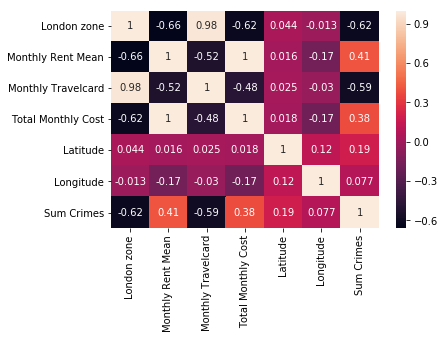

In [34]:
sns.heatmap(London_df_final_corr,annot=True)

The matrix confirms the __negative correlation__ between __"Total Monthly Cost"__ and __London Zone__.
Additionally, it highlights a __negative correlation__ between __London Zone__ and __Sum of Crimes__ (i.e. the sum of crimes tends to decrease in Districts further away from the London Central area).

##### 2.2 Create a plot of Total Monthly Cost based off of the London Zone

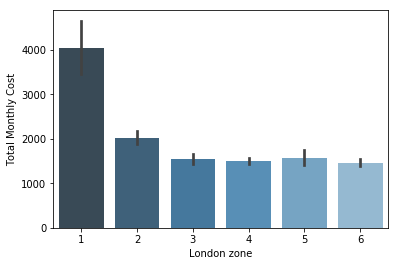

In [102]:
sns.barplot(x='London zone', y='Total Monthly Cost', data=London_df_final, palette="Blues_d")

##### 2.3 Create a plot of the total number of crimes for each London Zone.

In [129]:
London_df_final_gbyLz = London_df_final.groupby('London zone').mean()
London_df_final_gbyLz['London zone'] = London_df_final_gbyLz.index

In [130]:
London_df_final_gbyLz.index = range(0,len(London_df_final_gbyLz))

In [131]:
London_df_final_gbyLz

,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude,Sum Crimes,London zone
0,3916.500000,134.8,4051.300000,51.499583,-0.165972,89517.500000,1
1,1875.375000,134.8,2010.175000,51.504931,-0.113819,63290.375000,2
2,1394.666667,158.3,1552.966667,51.500417,-0.083102,54859.333333,3
3,1318.500000,194.0,1512.500000,51.522361,-0.144259,54079.500000,4
4,1342.375000,230.0,1572.375000,51.485174,-0.114444,34758.250000,5
5,1218.000000,246.6,1464.600000,51.562639,-0.146250,44308.000000,6


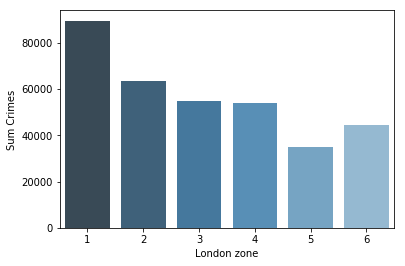

In [132]:
sns.barplot(x='London zone', y='Sum Crimes', data=London_df_final_gbyLz,palette="Blues_d")

The exploratory Data analysis shows how London __Zone 5__ presents the best combination of Total Monthly Cost-Crime Rate.

### Step 3

##### 3.1 Create a map of London with Districts superimposed on top

In [118]:
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium

In [119]:
address = 'London,UK'
geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.4893335, -0.144055084527687.


In [120]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, district, zone in zip(London_df_final['Latitude'], London_df_final['Longitude'], London_df_final['District'], London_df_final['London zone']):
    label = '{}, Zone {}'.format(district, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],radius=5,popup=label,color='blue',fill=True,fill_color='blue',fill_opacity=0.5,parse_html=True).add_to(map_london)  
map_london

##### 3.2 Define Foursquare credentials and version

In [121]:
# The code was removed by Watson Studio for sharing.

In [122]:
radius=500
LIMIT=100

##### 3.3 Explore Districts in London

In [123]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [124]:
London_districts = getNearbyVenues(names=London_df_final['District'], latitudes=London_df_final['Latitude'], longitudes=London_df_final['Longitude'])

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


##### 3.4 Analyse each District

In [126]:
London_onehot = pd.get_dummies(London_districts[['Venue Category']], prefix="", prefix_sep="")
London_onehot['District'] = London_districts['Neighborhood'] 
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]
London_onehot.head()

,District,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 3.5 Create the new dataframe and display the top 10 venues for each District

In [127]:
London_grouped = London_onehot.groupby('District').mean().reset_index()

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = London_grouped['District']

for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Golf Course,Pool,Bus Station,Park,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Fish Market,Fish & Chips Shop,Film Studio
1,Barnet,Café,Recording Studio,Bus Stop,Yoga Studio,English Restaurant,Food,Flea Market,Fish Market,Fish & Chips Shop,Film Studio
2,Bexley,Coffee Shop,Pub,Clothing Store,Italian Restaurant,Fast Food Restaurant,Supermarket,Plaza,Bakery,Portuguese Restaurant,Chinese Restaurant
3,Brent,Coffee Shop,Hotel,Clothing Store,Bar,Sporting Goods Shop,American Restaurant,Sandwich Place,Grocery Store,Burger Joint,Fast Food Restaurant
4,Bromley,Coffee Shop,Clothing Store,Bar,Gym / Fitness Center,Pizza Place,Burger Joint,Department Store,Bookstore,Furniture / Home Store,Electronics Store


##### 3.6 Cluster Districts

In [128]:
from sklearn.cluster import KMeans
kclusters = 4
London_grouped_clustering = London_grouped.drop('District', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)
kmeans.labels_[0:10]
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#Districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
London_merged = London_df_final
London_merged = London_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')
London_merged = London_merged[np.isfinite(London_merged['Cluster Labels'])]
London_merged['Cluster Labels'] = London_merged['Cluster Labels'].astype(int)
London_merged.head()

,District,London zone,Monthly Rent Mean,Monthly Travelcard,Total Monthly Cost,Latitude,Longitude,Sum Crimes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,5,1114,230.0,1344.0,51.560833,0.155833,37798.0,2,Golf Course,Pool,Bus Station,Park,Gym / Fitness Center,Martial Arts Dojo,Yoga Studio,Fish Market,Fish & Chips Shop,Film Studio
1,Barnet,4,1453,194.0,1647.0,51.625278,-0.151667,57489.0,3,Café,Recording Studio,Bus Stop,Yoga Studio,English Restaurant,Food,Flea Market,Fish Market,Fish & Chips Shop,Film Studio
2,Bexley,5,1161,230.0,1391.0,51.455000,0.150556,31913.0,0,Coffee Shop,Pub,Clothing Store,Italian Restaurant,Fast Food Restaurant,Supermarket,Plaza,Bakery,Portuguese Restaurant,Chinese Restaurant
3,Brent,3,1555,158.3,1713.3,51.558889,-0.281667,61295.0,0,Coffee Shop,Hotel,Clothing Store,Bar,Sporting Goods Shop,American Restaurant,Sandwich Place,Grocery Store,Burger Joint,Fast Food Restaurant
4,Bromley,5,1238,230.0,1468.0,51.403889,0.019722,46531.0,0,Coffee Shop,Clothing Store,Bar,Gym / Fitness Center,Pizza Place,Burger Joint,Department Store,Bookstore,Furniture / Home Store,Electronics Store


In [116]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged['Latitude'], London_merged['Longitude'], London_merged['District'], London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion 

The analysis shows that althought the Districts in the very Central area of London (Zone 1-2) might be the most appeling, the ones that are further away from the center present the best combination Total Monthly Cost/Quality of Living (as per Crime Rates and points of interest).
By sourcing the most common venues of each District via the Foursquare API and building the corresponding Dataframe, the K Means Clustering analysis highlights that also those Districts in Zone 5 and 6 have very similar patterns to the ones in more central zones.
It is therefore the London District of __Sutton__ (Zone 5) the London District that provides the __best value-for-money__ for a two-bedrooms.

## Conclusion

Based on the results of this analysis, we recommends to focus the research for renting a two-bedroom place in the London District of __Sutton__ (Zone 5), as it has the best combination of Total Monthly Cost and Crime Rate. Additionally, as per K Mean Clustering analysis, this District results in the same group of more central area, as it share  such that similar charateristics in terms of common venues and points of interest.